# Initialization

In [1]:
# Устанавливается необходимая версия пакетов для воспроизводимости экспирементов
# А так же для установки всех недостающих зависимостей

#'''Windows'''
#!python -m venv venv
#!.\venv\Scripts\activate
#!pip install -r requirements.txt

#'''Linux''';
#!python -m venv venv  
#!source ./venv/bin/activate  
#!pip install -r requirements.txt

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sys
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder

from datetime import datetime as dt # работа со временем
import json                     # преобразования строк со словарями в словари

In [3]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)

Python       : 3.10.4 (tags/v3.10.4:9d38120, Mar 23 2022, 23:13:41) [MSC v.1929 64 bit (AMD64)]
Numpy        : 1.22.2


In [4]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
#!pip freeze > requirements.txt

In [5]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

##  functions

In [6]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [7]:
'''Выводит barplot по количеству значений столбца'''
def show_value_counts(val_co):
    x = val_co.index
    y = val_co.values
    
    return sns.barplot(x=y, y=x)

##  Data

In [8]:
from pathlib import Path 

train = pd.read_pickle( Path("data", "all_auto_ru_09_09_2020.pickle_bz2"),
                compression='bz2')
test = pd.read_pickle( Path("data", "test.pickle_bz2"),
                compression='bz2')

## Предобработка и фичи на время разработки проекта

In [9]:
#Удаление дублирующихся строк
train_mod = train.drop_duplicates()
test_mod = test.drop_duplicates()

print('TRAIN','Rows =', np.shape(train_mod)[0],'Columns =', np.shape(train_mod)[1], sep=' ')
print('TEST ','Rows =', np.shape(test_mod)[0],'Columns =', np.shape(test_mod)[1], sep=' ') 

TRAIN Rows = 87264 Columns = 26
TEST  Rows = 34686 Columns = 32


In [10]:
#Разбираемся с препроцессингом и потерей половины строк в трейне
%store train_mod 
%store test_mod  

Stored 'train_mod' (DataFrame)
Stored 'test_mod' (DataFrame)


###  [Preprocessing_and_thoughts](./secondary_notebooks/Preprocessing_and_thoughts.ipynb)


###  [ML](./secondary_notebooks/ML.ipynb)

# Разведочный анализ

Есть датасет test, по которому нужно предсказать стоимость поддержанного автомобиля, при этом обучать модель для предсказаний на кагл на нём нельзя. Нужно использовать сторонний датасет. Мы взяли датасет из baseline, поскольку парсинг займет много времени, а в приоритетах проекта именно DS часть задачи предсказания цены на авто.

Для начала стоит понять, по каким данным будут делаться предсказания, затем подобрать подходящие из тренировочного датасета.

## Test

### Пропуски и дубли

In [11]:
print('Форма датасета до удаления дублей',test.shape)
test = test.drop_duplicates()
print('Форма датасета после             ',test.shape)


Форма датасета до удаления дублей (34686, 32)
Форма датасета после              (34686, 32)


Дублей нет! Посмотрим на пропуски:

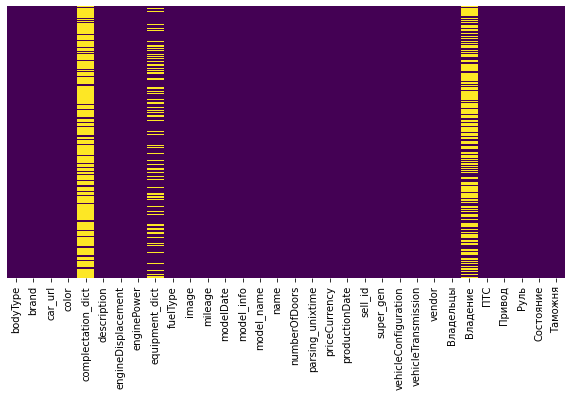

In [12]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(10,5))
sns_heatmap = sns.heatmap(
    test.isnull(), yticklabels=False, cbar=False, cmap='viridis')

Как видно, они очень плотно распределены всего по трём столбцам, что очень радует. Сразу видно, что столбец `complectation_dict` стоит выкинуть, поскольку в нем больше пропусков, чем данных. так же сразу стоит посмотреть на остальные столбцы с пропусками

#### complectation_dict

In [13]:
isna= test.complectation_dict.isna()
print('Заполненность данными:',len(isna[isna == False])/len(isna))

test.complectation_dict.dropna().iloc[0]

Заполненность данными: 0.18503142478233292


'{"id":"20026336","name":"Ambition","available_options":["heated-wash-system","airbag-passenger","lock","door-sill-panel","electro-mirrors","mirrors-heat","cooling-box","computer","seat-transformation","wheel-power","fabric-seats","airbag-side","abs","wheel-leather","climate-control-1","esp","adaptive-light","audiopreparation","ashtray-and-cigarette-lighter","front-centre-armrest","electro-window-back","16-inch-wheels","body-mouldings","condition","airbag-driver","isofix","aux","electro-window-front","light-sensor","hcc","ptf","rain-sensor","tyre-pressure","audiosystem-cd","front-seats-heat","wheel-configuration2","wheel-configuration1","immo","12v-socket","third-rear-headrest"]}'

Видно, что это словарь. Данных в этом столбце меньше 20 процентов.

Тут указан id, что может быть полезно только при объединении таблицы; имя, чем бы оно ни было; и перечисление возможных опций автомобиля. Это не несёт ценности. Этот столбец будет отфильтрован.

#### equipment_dict        

In [14]:
isna= test.equipment_dict.isna()
print('Заполненность данными:',len(isna[isna == False])/len(isna))

test.equipment_dict.dropna().iloc[0]

Заполненность данными: 0.7118145649541602


'{"engine-proof":true,"tinted-glass":true,"airbag-driver":true,"aux":true,"isofix":true,"electro-window-front":true,"ashtray-and-cigarette-lighter":true,"airbag-passenger":true,"computer":true,"high-beam-assist":true,"seat-transformation":true,"isofix-front":true,"wheel-power":true,"alarm":true,"lock":true,"door-sill-panel":true,"fabric-seats":true,"electro-mirrors":true,"airbag-rear-side":true,"electro-window-back":true,"steel-wheels":true,"ptf":true,"16-inch-wheels":true,"rain-sensor":true,"airbag-side":true,"audiosystem-cd":true,"dark-interior":true,"cooling-box":true,"condition":true,"abs":true,"power-child-locks-rear-doors":true,"front-seats-heat":true,"wheel-configuration2":true,"wheel-configuration1":true,"12v-socket":true,"park-assist-r":true}'

Видно, что это тоже словарь, но он содержит  уже вполне себе определенную комплектацию автомобиля. Эти данные можно будет использовать для преобразования в категориальные переменные. Оданко большое количество пропусков критично. Думаю, можно сделать отдельный признак, обозначающий отсутствие данных в этом столбце. Можно будет сделать данные не бинарными, а категориальными, содержащие три признака: есть, нет, отсутствую данные

#### Владение

In [15]:
isna= test.Владение.isna()
print('Заполненность данными:',len(isna[isna == False])/len(isna))

test.Владение.dropna().iloc[0]

Заполненность данными: 0.3458167560399008


'3 года и 2 месяца'

Столбец заполнен на 35% 

Видно, что это строка, которая указывает время владения. Предположительно, последнего владельца, но это нужно проверить. 

Данных маловато, но зато можно будет сделать из них бинарный признак, указал ли водитель время использования или нет. Но скорее всего после проверки этот столбец не будет использоваться вовсе.

In [16]:
test.columns

Index(['bodyType', 'brand', 'car_url', 'color', 'complectation_dict',
       'description', 'engineDisplacement', 'enginePower', 'equipment_dict',
       'fuelType', 'image', 'mileage', 'modelDate', 'model_info', 'model_name',
       'name', 'numberOfDoors', 'parsing_unixtime', 'priceCurrency',
       'productionDate', 'sell_id', 'super_gen', 'vehicleConfiguration',
       'vehicleTransmission', 'vendor', 'Владельцы', 'Владение', 'ПТС',
       'Привод', 'Руль', 'Состояние', 'Таможня'],
      dtype='object')

Посмотрим на все колонки

In [17]:
test.describe()

,mileage,modelDate,numberOfDoors,parsing_unixtime,productionDate,sell_id
count,34686.000000,34686.000000,34686.000000,3.468600e+04,34686.000000,3.468600e+04
mean,162009.767889,2007.074728,4.450816,1.603287e+09,2009.264602,1.098300e+09
std,100676.559489,7.415894,0.703040,1.493071e+05,7.047661,1.911225e+07
min,1.000000,1904.000000,0.000000,1.603107e+09,1904.000000,2.665000e+03
25%,91153.500000,2004.000000,4.000000,1.603221e+09,2006.000000,1.099049e+09
50%,149779.500000,2008.000000,5.000000,1.603254e+09,2011.000000,1.100911e+09
75%,215000.000000,2012.000000,5.000000,1.603290e+09,2014.000000,1.101245e+09
max,1000000.000000,2020.000000,5.000000,1.603710e+09,2020.000000,1.101375e+09


Видно, что в дате всего 5 численных переменных, но sell_id не считается

### bodyType

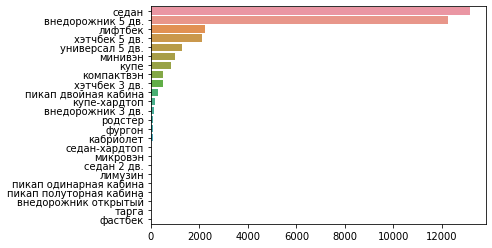

In [18]:
show_value_counts(test.bodyType.value_counts());

Этот столбец определяет тип кузова автомобиля. Почему-то в датасете очень много внедорожников с 5 дверьми, а есть внедорожники с 3мя дверьми. Подобные строки будут обозначенны одним видом, как один тип кузова, потому-что количество дверей - это отдельный признак.

Видно, что часть авто являются редкими. Их можно объединить в один признак. Неплохая вариация для моделей

### brand

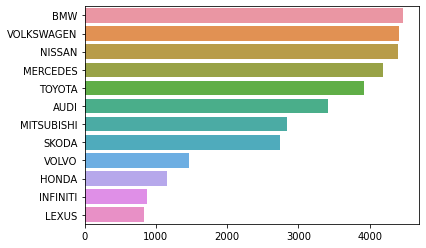

In [19]:
show_value_counts(test.brand.value_counts());

Красивое и нормальное распределение брендов, можно превратить в dummy-переменные

### car_url

In [20]:
test.car_url[0]

'https://auto.ru/cars/used/sale/skoda/octavia/1100575026-c780dc09/'

Это ссылки на странички проданых авто, вот [одна из них](https://auto.ru/cars/used/sale/skoda/octavia/1100575026-c780dc09/). 

Для модели это мусор, но можно спарсить добавочные данные с сайта. Но есть ссылки и нерабочие

In [21]:
test[test.mileage == test.mileage.max()].car_url

4647     https://auto.ru/cars/used/sale/audi/80/1101251...
6568     https://auto.ru/cars/used/sale/volvo/240_serie...
9463     https://auto.ru/cars/used/sale/bmw/7er/1092626...
9888     https://auto.ru/cars/used/sale/bmw/5er/1099209...
17203    https://auto.ru/cars/used/sale/mercedes/w124/1...
18308    https://auto.ru/cars/used/sale/mercedes/s_klas...
20164    https://auto.ru/cars/used/sale/toyota/corolla_...
21459    https://auto.ru/cars/used/sale/toyota/land_cru...
25168    https://auto.ru/cars/used/sale/volkswagen/tran...
25464    https://auto.ru/cars/used/sale/volkswagen/jett...
28391    https://auto.ru/cars/used/sale/mitsubishi/cari...
Name: car_url, dtype: object

### color

### complectation_dict
 
[Много пропусков и нуль информации](#complectation_dict), поэтому выкенем этот столбец

In [22]:
# test = test.drop(['complectation_dict'], axis='columns')

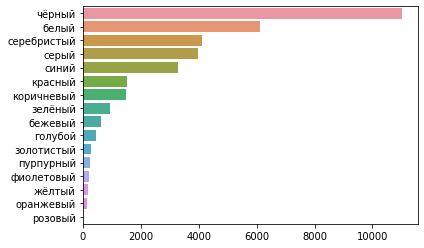

In [23]:
show_value_counts(test.color.value_counts());

Готовая для модели колонка, распределена нормально. Стоит преобразовать в dummy, можно сделать призак: редкий цвет. Он может повысить предсказательную силу моделей

### description

In [24]:
test.description[0]

'Все автомобили, представленные в продаже, проходят тщательную проверку по более 40 параметрам. Предоставляем гарантию юридической чистоты, а так же год технической гарантии на двигатель и КПП. Бесплатный тест-драйв. Возможно оформление автомобиля в кредит!\n\nПреимущества автокредитования:\n— Первоначальный взнос от 0%;\n— Более 30 кредитных программ;\n— Процентная ставка от 6% годовых;\n— Срок кредита от 6 месяцев до 7 лет;\n— Оформление кредита по двум документам;\n— Досрочное погашение без штрафов и комиссий;\n— Сумма кредита до 2 млн рублей;\n— Оформление КАСКО – по желанию;\n— Без справок и поручителей.\n\nСотрудничаем с 12 аккредитованными и сертифицированными банками РФ, среднее время ожидания решения банка 20–30 минут.\n\nПри покупке автомобиля по программе «Trade-in – выгодный обмен» или в кредит, получите дополнительную скидку до 80 000 рублей на данный автомобиль!\n\nЗаписаться на тест-драйв, а так же получить подробную информацию можно у специалистов автоцентра по указанно

Интереснейшая колонка! Содержит комментарий продавца. Проверим, есть ли одинаковые тескты.

In [25]:
test.description.replace('\n','')

0        Все автомобили, представленные в продаже, прох...
1        ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...
2        Все автомобили, представленные в продаже, прох...
3        КОМПЛЕКТ ЗИМНЕЙ (ЛЕТНЕЙ) РЕЗИНЫ ПО СЕЗОНУ В ПО...
4        ЛОТ: 01220889\nАвтопрага Север\n\nВы можете по...
                               ...                        
34681    Продается BMW 316i в отличном состоянии. Прода...
34682                       Продаётся отличный автомобиль.
34683                                    Хорошее состояние
34684    Автомобиль в идеальном состоянии . Куплен новы...
34685     Пробег реальный, состояние отличное! Авторска...
Name: description, Length: 34686, dtype: object

In [26]:
test.description.value_counts().values

array([264, 259, 211, ...,   1,   1,   1], dtype=int64)

Есть одинаковые тексты, кажется, их довольно много. Это автодиллеры.

In [27]:
desc_VC = pd.Series(test.description.value_counts())
print(len(desc_VC[desc_VC != 1]),' - Количество повторений количества строк:') 
print(sum(desc_VC[desc_VC != 1]),'- Общее количество машин с таким описанием:')

258  - Количество повторений количества строк:
3212 - Общее количество машин с таким описанием:


Часть из них от диллеров, часть - короткие коминтарии по типу: "Хорошая"

In [28]:
cherepters_count = []

for i in test.index:
    cherepters_count.append(len(test.description[i]))
    
cherepters_count = pd.Series(cherepters_count)

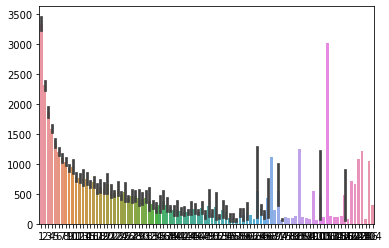

In [29]:
show_value_counts(cherepters_count.value_counts());

Есть группы, видно несколько диллеров.

In [30]:
min(cherepters_count)

1

!!! Удалить \n отовсюду

In [31]:
cherepters_count[cherepters_count == 8] # Есть малословные комментарии

3121     8
5194     8
22939    8
28518    8
31255    8
dtype: int64

Можно обработать через word2vec и кластеризовать. Однако это требует много ресурсов и не факт, что признак будет значим, но это очень круто.

Можно легматизировать(или как там, оставить корень слова) и использовать словари положительных и отрицательных слов для формирования веса для модели. 

### engineDisplacement

In [32]:
test.engineDisplacement.value_counts()

2.0 LTR    7391
1.6 LTR    4973
3.0 LTR    3915
1.8 LTR    3349
2.5 LTR    2477
2.4 LTR    1745
3.5 LTR    1710
1.4 LTR    1635
1.5 LTR     725
1.2 LTR     485
4.4 LTR     447
2.8 LTR     384
4.7 LTR     377
1.3 LTR     365
5.5 LTR     361
4.0 LTR     356
3.2 LTR     348
4.5 LTR     346
2.1 LTR     271
3.7 LTR     242
2.2 LTR     236
4.2 LTR     228
1.9 LTR     221
2.3 LTR     203
2.7 LTR     189
3.6 LTR     183
5.6 LTR     170
5.0 LTR     158
5.7 LTR     135
2.9 LTR     131
4.6 LTR     108
3.1 LTR      88
4.8 LTR      84
1.7 LTR      59
1.0 LTR      57
3.8 LTR      57
2.6 LTR      55
 LTR         55
6.0 LTR      53
0.7 LTR      53
3.3 LTR      44
3.4 LTR      36
4.1 LTR      35
4.3 LTR      32
5.4 LTR      31
6.2 LTR      28
5.2 LTR      12
5.9 LTR      12
6.3 LTR       8
5.8 LTR       7
6.6 LTR       6
4.9 LTR       4
1.1 LTR       4
3.9 LTR       1
5.3 LTR       1
Name: engineDisplacement, dtype: int64

In [33]:
#test.loc[test['engineDisplacement']==' LTR'] = '1.0'
#pd.Series(map(lambda x:x.replace('LTR', ''),test.engineDisplacement))

Ёмкость двигателя. Превратить в float. хороший численный признак

### enginePower #upgrade изменить на гистограму после предобработки

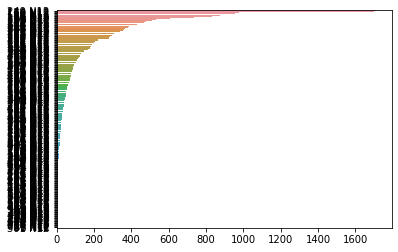

In [34]:
show_value_counts(test.enginePower.value_counts());

Красивое нормальное распределение

In [35]:
pd.Series(['N12' in i for i in test.enginePower]).value_counts()

True    34686
dtype: int64

Везде содержится строчка 'N12'. Её можно убрать и вычесть минимальное значение

In [36]:
# pd.Series(map(lambda x: int(x.replace('N12', '')),test.enginePower))
# min(pd.Series(map(lambda x: int(x.replace('N12', '')),test.enginePower)))

### equipment_dict

In [37]:
test.equipment_dict[0] 

'{"engine-proof":true,"tinted-glass":true,"airbag-driver":true,"aux":true,"isofix":true,"electro-window-front":true,"ashtray-and-cigarette-lighter":true,"airbag-passenger":true,"computer":true,"high-beam-assist":true,"seat-transformation":true,"isofix-front":true,"wheel-power":true,"alarm":true,"lock":true,"door-sill-panel":true,"fabric-seats":true,"electro-mirrors":true,"airbag-rear-side":true,"electro-window-back":true,"steel-wheels":true,"ptf":true,"16-inch-wheels":true,"rain-sensor":true,"airbag-side":true,"audiosystem-cd":true,"dark-interior":true,"cooling-box":true,"condition":true,"abs":true,"power-child-locks-rear-doors":true,"front-seats-heat":true,"wheel-configuration2":true,"wheel-configuration1":true,"12v-socket":true,"park-assist-r":true}'

Видно, что это тоже словарь, но он содержит уже вполне себе определенную комплектацию автомобиля. Эти данные можно будет использовать для преобразования в категориальные переменные. Оданко **28% пропусков** - это критично. Думаю, можно сделать отдельный признак, обозначающий отсутствие данных в этом столбце. Можно будет сделать данные не бинарными, а категориальными, содержащие три признака: есть, нет, отсутствуют данные

### fuelType

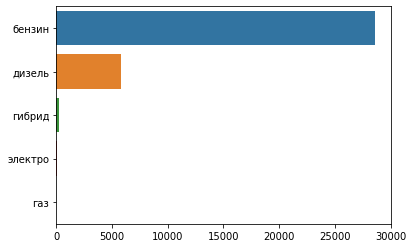

In [38]:
show_value_counts(test.fuelType.value_counts());

Видно, что автомобили на гибридном питании, элекртичесве и газе - большая редкость, их можно объединить в один признак или же натренировать под эти категории отдельную модель

### image

In [39]:
test.image.sample(10)

1892     https://avatars.mds.yandex.net/get-autoru-vos/...
5110     https://avatars.mds.yandex.net/get-autoru-vos/...
9643     https://autoru.naydex.net/lICN99c69/9bc7d3Rr7k...
2602     https://avatars.mds.yandex.net/get-autoru-vos/...
1401     https://avatars.mds.yandex.net/get-autoru-vos/...
30152    https://autoru.naydex.net/f1bm7A798/f15c727Yw/...
8610     https://avatars.mds.yandex.net/get-autoru-vos/...
15397    https://autoru.naydex.net/LxPU17803/f5b8d77S/u...
13158    https://avatars.mds.yandex.net/get-autoru-vos/...
3099     https://avatars.mds.yandex.net/get-autoru-vos/...
Name: image, dtype: object

url ссылок на изображения автомобиля сломаны, их в таком виде нельзя использовать, даже, если бы хотелось. Столбец подлежит изгнанию из датасета.

Вообще можно было бы натренировать модель, которая оценивала бы стоимость автомобиля по внешнему виду, это очень интересно, но займет слишком много ресурсов, да и это тема для отедльного проекта

### mileage #upgrade

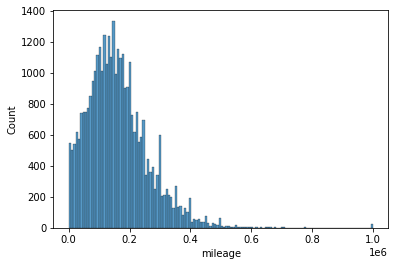

In [40]:
sns.histplot(data=test.mileage);

По распределению видно:
- Оно нормальное
- Есть относительно плотная кучка максимальных значений, которая выбивается из нормального распределения, на них сейчас посмотрим

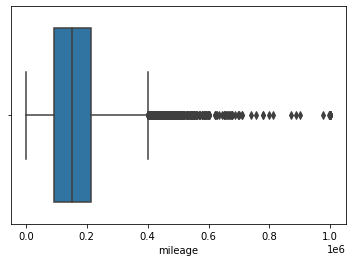

In [41]:
sns.boxplot(x=test.mileage);

In [42]:
print('минимум:',test.mileage.min())
print('медиана:',test.mileage.median())
print('максимум:',test.mileage.max())

минимум: 1
медиана: 149779.5
максимум: 1000000


Минимум в 1 км - вполне возможно, авто новое
Максимум в миллион километров - это примерно 3 года езды с скоростью в 60 км/ч по 15 часов в день, что похоже тоже возможно

Лучше всего эту колонку логарифмизировать, так, чтобы логарифм не очень быстро перестал изменяться.

### modelDate

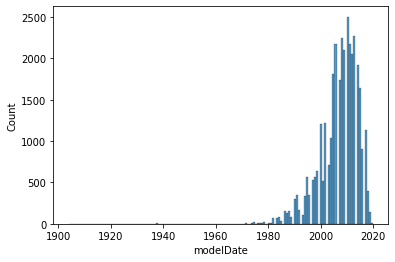

In [43]:
sns.histplot(data=test.modelDate,bins=150);

Дата выпуска модели. Все отлично

Для модели можно:
- от всех дат отрезать первую. 
- соединить её с еще одной датой, чтобы избавиться от мультиколлиниарности

### model_info

In [44]:
test.model_info[4]

'{"code":"OCTAVIA","name":"Octavia","ru_name":"Октавия","morphology":{"gender":"FEMININE"},"nameplate":{"code":"","name":"","semantic_url":""}}'

Эта колонка содержит название модели, то, как она произносится, указан её род... да и в общем, это все. Колонка на выброс, данных в ней нет

### model_name

In [45]:
test.model_name.sample(4)

7100      XC60
34021    JETTA
24641     POLO
748      FABIA
Name: model_name, dtype: object

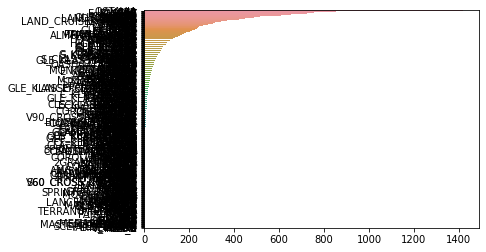

In [46]:
show_value_counts(test.model_name.value_counts());

Слева тут можно увидить распределение длинны названия моделей слева от популярности марки, но что-то я отвлекся. 

In [47]:
print(f'Всего в датасете {test.model_name.nunique()} модели от одного и разных брендов')

Всего в датасете 544 модели от одного и разных брендов


С этим столбцом есть кое-что интересное. По сути своей, когда мы, люди, говорим о цене автомобиля, то первая значимая часть - это марка, всем понятно, что porche обычно дороже автоваза. Вторая - модель автомобиля. Третяя - комплектация.

И Если первые две части можно отосительно легко перечислить, то комлпектация авто сильно увеличивает вариативность машин и возможных цен. Поэтому предлагаю спарсить средние цены автомобилей марок и моделей в датасете, чтобы изменять их стоимость, относительно выводов модели. Честно ли это? - Да. Потому-что DS это не только про модели, но и про анализ и поиск эффективных подходов.

### name #upgrade че это такое

In [48]:
pd.set_option('display.max_columns', None)

In [49]:
test.brand.unique()

array(['SKODA', 'AUDI', 'HONDA', 'VOLVO', 'BMW', 'NISSAN', 'INFINITI',
       'MERCEDES', 'TOYOTA', 'LEXUS', 'VOLKSWAGEN', 'MITSUBISHI'],
      dtype=object)

модель - кузов, база, на которую все крепится.

In [50]:
test[test.brand=='BMW'].sample(4)

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,image,mileage,modelDate,model_info,model_name,name,numberOfDoors,parsing_unixtime,priceCurrency,productionDate,sell_id,super_gen,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня
8745,внедорожник 5 дв.,BMW,https://auto.ru/cars/used/sale/bmw/x3/11012676...,белый,"{""id"":""21040496"",""name"":""xDrive20i"",""available...","Рестайлинговый BMW X3, в прекрасном состоянии,...",2.0 LTR,184 N12,"{""cruise-control"":true,""tinted-glass"":true,""es...",бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,119000,2014,"{""code"":""X3"",""name"":""X3"",""ru_name"":""Х3"",""morph...",X3,20i xDrive 2.0 AT (184 л.с.) 4WD,5,1603112334,RUB,2014,1101267699,"{""id"":""20156807"",""name"":""20i"",""nameplate"":""20i...",ALLROAD_5_DOORS AUTOMATIC 2.0,автоматическая,EUROPEAN,1 владелец,5 лет и 5 месяцев,Оригинал,полный,Левый,Не требует ремонта,Растаможен
8586,седан,BMW,https://auto.ru/cars/used/sale/bmw/7er/1100879...,синий,"{""id"":""21038643"",""name"":""730Ld xDrive"",""availa...",«Inchcape Certified» - Первый международный оф...,3.0 LTR,249 N12,"{""cruise-control"":true,""roller-blind-for-rear-...",дизель,https://avatars.mds.yandex.net/get-autoru-vos/...,64870,2015,"{""code"":""7ER"",""name"":""7 серии"",""ru_name"":""7 се...",7ER,730Ld xDrive 3.0d AT (249 л.с.) 4WD,4,1603111728,RUB,2017,1100879562,"{""id"":""21200795"",""name"":""730L"",""nameplate"":""73...",SEDAN AUTOMATIC 3.0,автоматическая,EUROPEAN,2 владельца,NaN,Оригинал,полный,Левый,Не требует ремонта,Растаможен
10260,лифтбек,BMW,https://auto.ru/cars/used/sale/bmw/5er/1087535...,чёрный,"{""id"":""5044629"",""name"":""535i"",""available_optio...","Продаю GT 2010 года, американка, пробег честн...",3.0 LTR,306 N12,"{""cruise-control"":true,""tinted-glass"":true,""es...",бензин,https://autoru.naydex.net/lICN99c69/9bc7d3Rr7k...,200000,2009,"{""code"":""5ER"",""name"":""5 серии"",""ru_name"":""5 се...",5ER,535i 3.0 AT (306 л.с.),5,1603118362,RUB,2010,1087535600,"{""id"":""5044622"",""name"":""Gran Turismo"",""namepla...",LIFTBACK AUTOMATIC 3.0,автоматическая,EUROPEAN,3 или более,1 год и 9 месяцев,Оригинал,задний,Левый,Не требует ремонта,Растаможен
29512,седан,BMW,https://auto.ru/cars/used/sale/bmw/5er/1101312...,чёрный,NaN,Крашеных деталей нет совсем.\nТехнически без н...,2.5 LTR,204 N12,"{""cruise-control"":true,""tinted-glass"":true,""es...",бензин,https://autoru.naydex.net/f1bm7A798/f15c727Yw/...,172000,2009,"{""code"":""5ER"",""name"":""5 серии"",""ru_name"":""5 се...",5ER,523i 2.5 AT (204 л.с.),4,1603561573,RUB,2011,1101312268,"{""id"":""6088660"",""name"":""523"",""nameplate"":""523i...",SEDAN AUTOMATIC 2.5,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,задний,Левый,Не требует ремонта,Растаможен


In [51]:
test[test.brand=='VOLVO'].name

6226     2.4d AT (190 л.с.) 4WD
6227      2.0 AT (190 л.с.) 4WD
6228     2.4d AT (205 л.с.) 4WD
6229          2.4 AT (170 л.с.)
6230         2.0 AMT (145 л.с.)
                  ...          
34147     2.4 AT (200 л.с.) 4WD
34148        2.0 AMT (145 л.с.)
34149         2.0 AT (213 л.с.)
34150         1.5 AT (152 л.с.)
34151         1.8 MT (125 л.с.)
Name: name, Length: 1463, dtype: object

In [52]:
test.name.sample(5)

14866    FX45 4.5 AT (315 л.с.) 4WD
891               1.6 AT (102 л.с.)
13920        2.5 CVT (169 л.с.) 4WD
13234            2.5 CVT (173 л.с.)
24584            1.4 AMT (122 л.с.)
Name: name, dtype: object

In [53]:
print(test_mod.name[0])
print(test_mod.model_name[0])

1.2 AMT (105 л.с.)
OCTAVIA


Тут указан объём двигателя, тип коробки передач и количество лошадиных сил, так же количество колёс в приводе. Можно исключить, т.к. вся эта информация есть в [этой](#super_gen) колонке

### numberOfDoors

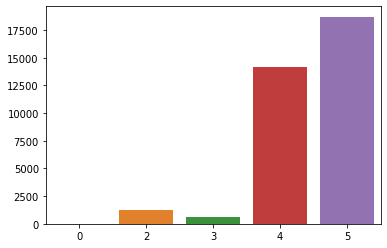

In [54]:
x = test.numberOfDoors.value_counts().index
y = test.numberOfDoors.value_counts().values
sns.barplot(x=x, y=y);

Хоршие категориальные признаки, пойдут в dummy. 

Только в датасете есть машина без дверей, наверное это танк

In [55]:
test[test.numberOfDoors == 0]

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,image,mileage,modelDate,model_info,model_name,name,numberOfDoors,parsing_unixtime,priceCurrency,productionDate,sell_id,super_gen,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня
16944,кабриолет,MERCEDES,https://auto.ru/cars/used/sale/mercedes/simple...,белый,NaN,"на ходу. 1904 год. стоит в гараже, пылится.Кат...",5.3 LTR,32 N12,NaN,бензин,https://autoru.naydex.net/ESooa9149/468b9eoMem...,48000,1904,"{""code"":""SIMPLEX"",""name"":""Simplex"",""ru_name"":""...",SIMPLEX,5.3 MT (32 л.с.),0,1603245843,RUB,1904,1093802104,"{""id"":""21743990"",""displacement"":5322,""engine_t...",CABRIO MECHANICAL 5.3,механическая,EUROPEAN,1 владелец,6 лет и 8 месяцев,Оригинал,задний,Правый,Не требует ремонта,Растаможен


Нет, это кабриолет

In [56]:
test.at[16944, 'numberOfDoors'] = 2

### parsing_unixtime

In [57]:
test.parsing_unixtime[0]

1603226273

Судя по всему в этом столбце находится дата парсинга в формате unixtime

In [58]:
parsing_date = pd.Series(map(lambda x:dt.fromtimestamp(x),test.parsing_unixtime))

parsing_date.max()-parsing_date.min()

Timedelta('6 days 23:29:18')

Разница во времени парсинга - незначительная и состовяет 6 дней. За это время возраст авто не изменился, поэтому можно использовать медианное время для вычисления возраста авто. 

In [59]:
parsing_date.median()

Timestamp('2020-10-21 07:22:13')

### priceCurrency

In [60]:
test.priceCurrency.sample(5)

11581    RUB
2741     RUB
9391     RUB
4100     RUB
18666    RUB
Name: priceCurrency, dtype: object

In [61]:
test.priceCurrency.unique()

array(['RUB'], dtype=object)

В этом столбе предоставленна валюта, в которой укзазана цена автомобилей. Это рубль, нет смысла использовать найденную информацию о стоимости автомобилей в другой валюте. Этот столбец только что стал неинформативным. Выкидываем.

### productionDate

In [62]:
test.productionDate.sample(5)

26552    2011
33107    2002
2681     2015
28082    2005
4585     2017
Name: productionDate, dtype: int64

Год выпуска автомобиля. Может быть весьма полезным, если связать его со временем парсинга или годом выпуска модели.

### sell_id

In [63]:
test.sell_id.sample(5)

5428     1093566046
29342    1101307173
3629     1100820540
23337    1100931266
5218     1100804878
Name: sell_id, dtype: int64

Просто id продажи, можно было бы ворваться в базу данных auto.ru и стянуть данные о продажах, чтобы узнать цены автомобилей в тесте и тем самым набрать максимальный балл из возможных. Но это не наши профиль и уровень благопорядочности. Выкидываем колонку

### super_gen

In [64]:
test.super_gen[0]

'{"id":"10373605","displacement":1197,"engine_type":"GASOLINE","gear_type":"FORWARD_CONTROL","transmission":"ROBOT","power":105,"power_kvt":77,"human_name":"1.2 AMT (105 л.с.)","acceleration":10.5,"clearance_min":155,"fuel_rate":5}'

In [65]:
import json
json.loads(test.super_gen[0])

{'id': '10373605',
 'displacement': 1197,
 'engine_type': 'GASOLINE',
 'gear_type': 'FORWARD_CONTROL',
 'transmission': 'ROBOT',
 'power': 105,
 'power_kvt': 77,
 'human_name': '1.2 AMT (105 л.с.)',
 'acceleration': 10.5,
 'clearance_min': 155,
 'fuel_rate': 5}

Это словарь с общими характеристиками автомобиля, не заисящими от бренда

| Ключ          | Значение              | Пояснение                                                                             |
| ------------- | --------------------- | ------------------------------------------------------------------------------------- |
| id            | 20228954              | неинформативный номер                                                                 |
| displacement  | 1969                  | Рабочий объём двигателя в $см^2$                                                      |
| engine_type   | GASOLINE              | Тип двигателя(топливо)                                                                |
| gear_type     | ALL_WHEEL_DRIVE       | Тип привода                                                                           |
| transmission  | AUTOMATIC             | Коробка передач                                                                       |
| power         | 320                   | мощность двигателя в лошадиных силах                                                  |
| power_kvt     | 235                   | мощность двигателя в киловатах                                                        |
| human_name    | 2.0 AT (320 л.с.) 4WD | Краткие Обозначения объема двигателя, коробки передач, лошадиных сил и типа привода   |
| acceleration  | 6.5                   | Количество секунд для разгона до сотни км/ч                                           |
| clearance_min | 237                   | Дорожный просвет - расстояние от дна автомобился до поверхности асфальта в милиметрах |
| fuel_rate     | 8                     | Расход топлива в литрах на 100 км                                                     |


### vehicleConfiguration

In [66]:
test.vehicleConfiguration.sample(5)

33289            SEDAN AUTOMATIC 2.5
29067            SEDAN AUTOMATIC 2.4
4889     HATCHBACK_5_DOORS ROBOT 1.2
1834              LIFTBACK ROBOT 1.8
1720              LIFTBACK ROBOT 1.4
Name: vehicleConfiguration, dtype: object

Столбец, говорящий о типе кузова автомобиля, типе трансмиссии  и объеме двигателя. Его можно выкинуть, т.к. он дублирует уже полученную информацию.

### vehicleTransmission

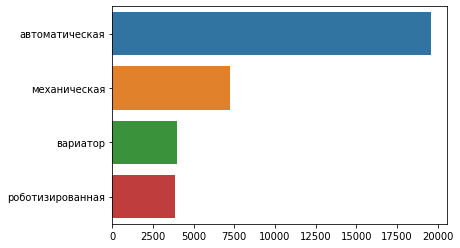

In [587]:
show_value_counts(test.vehicleTransmission.value_counts());

Колонка с типом коробки передач. Неплохие признаки, осталось сравнить их с предыдущими словарями.

### vendor

In [68]:
test.vendor.value_counts()

EUROPEAN    20682
JAPANESE    14004
Name: vendor, dtype: int64

Категориальный признак

Отличает стран-продавцов авто, имеет смысл расширить европейского продавца до конкретных стран.

### Владельцы

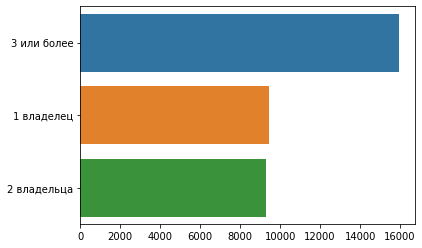

In [72]:
show_value_counts(test.Владельцы.value_counts());

Хороший категориальный признак, но, все же лучше превратить его в числовой.

### Владение

In [15]:
isna= test.Владение.isna()
print('Заполненность данными:',len(isna[isna == False])/len(isna))

test.Владение.dropna().iloc[0]

Заполненность данными: 0.3458167560399008


'3 года и 2 месяца'

Столбец заполнен на 35% 

Видно, что это строка, которая указывает время владения. Предположительно, последнего владельца, но это нужно проверить. 

Данных маловато, но зато можно будет сделать из них бинарный признак, указал ли водитель время использования или нет. Но скорее всего после проверки этот столбец не будет использоваться вовсе.

### ПТС

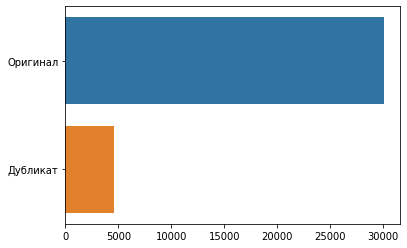

In [78]:
show_value_counts(test.ПТС.value_counts());

Паспорт Технического Средства. По сути паспорт автомобиля. Дубликат нужен в случае утери или если в оригинале закончились строки под количество владельцев авто. Признак можно оставить и посмотреть, какое он оказывает влияние. 

### Привод

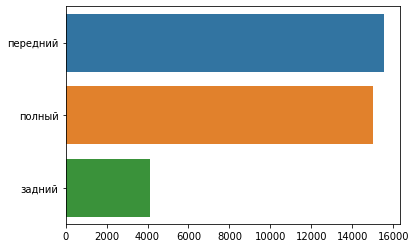

In [82]:
show_value_counts(test.Привод.value_counts());

Привод авто, три признака. Полный привод - дороже. Это важный признак.

### Руль

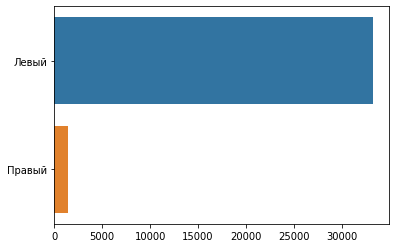

In [85]:
show_value_counts(test.Руль.value_counts());

Совсем немного праворульных автомобилей, что понятно, ведь машины продаются под российский рынок. Признак стоит оставить, он может быть маркером для модели.

### Состояние

In [89]:
print(test.Состояние.unique())

['Не требует ремонта']


Все машины не требуют ремонта, это неинформативный признак. Колонка выкидывается из датасета.

### Таможня

In [92]:
print(test.Таможня.unique())

['Растаможен']


Все автомобили расстоможены, этот признак неинформативный. Колонка выкидывается из датасета

## Train

Важно заметить, что мы не делали предобработку, это потому, что нужно сравнить тестовый датасет с тренировочным, ведь некоторых данных для обучения может и не быть.

In [93]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89378 entries, 0 to 89377
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              89377 non-null  object 
 1   brand                 89378 non-null  object 
 2   color                 89378 non-null  object 
 3   fuelType              89378 non-null  object 
 4   modelDate             89377 non-null  float64
 5   name                  89377 non-null  object 
 6   numberOfDoors         89377 non-null  float64
 7   productionDate        89378 non-null  int64  
 8   vehicleConfiguration  89377 non-null  object 
 9   vehicleTransmission   89377 non-null  object 
 10  engineDisplacement    89377 non-null  object 
 11  enginePower           89377 non-null  float64
 12  description           86124 non-null  object 
 13  mileage               89378 non-null  int64  
 14  Комплектация          89378 non-null  object 
 15  Привод             

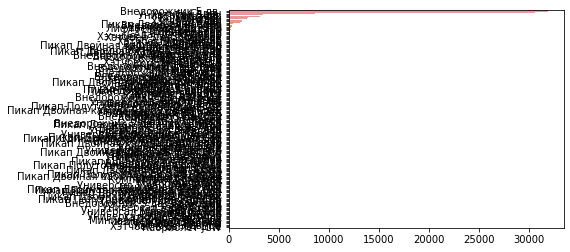

In [97]:
show_value_counts(train.bodyType.value_counts());

# Предобработка 

# Генерация фич

# Модели



Были опробованны модели:
- [Logistic regression](./secondary_notebooks/linear_regression.ipynb) 
- Desicion tree
- DBSCAN
- ...

In [104]:
'''Если нажать - через три минуты покажется результат "лучшей модели"   '''

from IPython.display import display
from ipywidgets import Button 

# Создаем кнопку с нужными параметрами
button1 = Button(description="Я линейная!", 
                        button_style='success'  )

def on_button_clicked(b): # Описываем обработчик события
    %run ./secondary_notebooks/linear_regression.ipynb
button1.on_click(on_button_clicked) # Назначаем этот обработчик на событие "on_click"

display(button1) # Отображаем кнопку 

Button(button_style='success', description='Я линейная!', style=ButtonStyle())